# 目次

- データ確認
- 特徴量エンジニアリング
- データ分割
- 学習、予測、評価
- 特徴量重要度
- パラメータチューニング
- アンサンブル

# ライブラリ

In [1]:
# データ処理
import csv
import numpy as np
import pandas as pd
import scipy.stats as stats
pd.options.display.float_format = '{:.0f}'.format
from sklearn.preprocessing import LabelEncoder # ラベルエンコーディング

# データ準備
from sklearn.model_selection import train_test_split # データ分割
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

# アルゴリズム
from sklearn.linear_model import LinearRegression # 線形回帰
from sklearn.svm import SVC, LinearSVC # サポートベクトルマシン
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.linear_model import SGDClassifier # 確率的勾配降下法
from sklearn.cluster import KMeans # k-means
from sklearn.neighbors import KNeighborsClassifier # K近傍法（分類）
from sklearn.neighbors import KNeighborsRegressor # K近傍法（回帰）
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
import xgboost as xgb # XGBoost
import lightgbm as lgb # LightGBM
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB # ナイーブベイズ分類木
from sklearn.linear_model import Perceptron # パーセプトロン

# パラメータ・チューニング
import optuna

# 評価
from sklearn.metrics import confusion_matrix # 混同行列
from sklearn.model_selection import learning_curve # 学習曲線
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss, roc_auc_score # 各評価指標
from sklearn import metrics
from sklearn.metrics import roc_auc_score # AUC

# 描画
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')
from tqdm import tqdm # プログレスバー
mplstyle.use('fast')

# 表示調整
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP'] # 日本語対応
plt.rcParams["figure.figsize"] = [20,5] # 表示サイズ
plt.rcParams["font.size"] = 10 # 文字サイズ
# HTML対応
from IPython.core.display import display, HTML
# 全表示対応
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# データ確認

In [2]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
gender_df = pd.read_csv("./gender_submission.csv")

In [3]:
train_df.head()
test_df.head()
gender_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,8,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,8,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,10,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,9,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12,NaN,S


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [4]:
train_df.shape
test_df.shape
gender_df.shape

(891, 12)

(418, 11)

(418, 2)

In [5]:
train_df.info()
print("="*40)
test_df.info()
print("="*40)
gender_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [6]:
train_df.describe(include=['O'])
test_df.describe(include=['O'])
gender_df.describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Ilieff, Mr. Ylio",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


,PassengerId,Survived
count,418,418
mean,1100,0
std,121,0
min,892,0
25%,996,0
50%,1100,0
75%,1205,1
max,1309,1


## 相関確認

In [7]:
# Survivedの割合確認
train_df[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,1
1,2,0
2,3,0


In [8]:
train_df[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Sex,Survived
0,female,1
1,male,0


In [9]:
train_df[["Parch", "Survived"]].groupby(["Parch"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Parch,Survived
3,3,1
1,1,1
2,2,0
0,0,0
5,5,0
4,4,0
6,6,0


In [10]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,1
2,2,0
0,0,0
3,3,0
4,4,0
5,5,0
6,8,0


## 欠損値処理

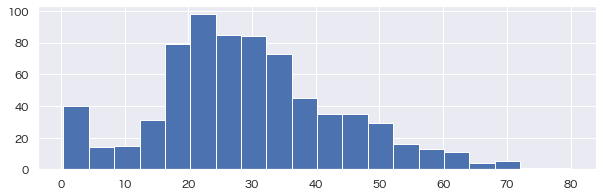

<Figure size 720x216 with 0 Axes>

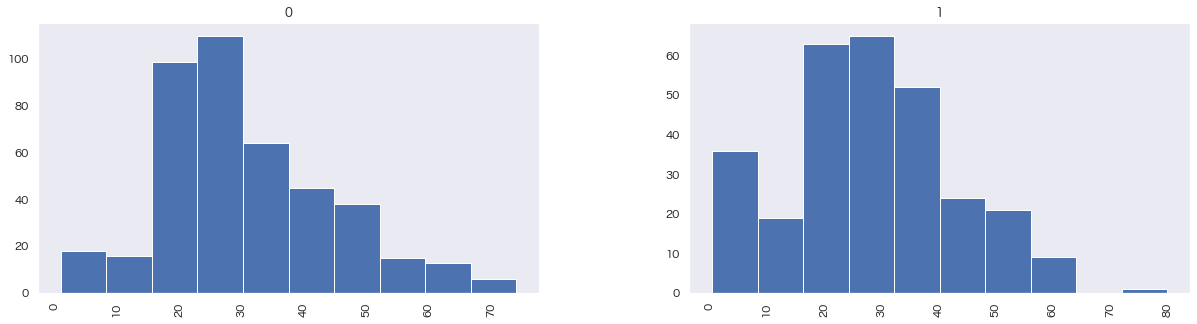

In [11]:
combine = [train_df, test_df]

# Ageの欠損値を削除
Age_drop = train_df["Age"].dropna()

# ヒストグラム
plt.figure(figsize=[10,3])
plt.grid()
Age_drop.hist(bins=20) # bin:範囲（階級）

# Ageを　Survived=0　と Survived=1　別に可視化
plt.figure(figsize=[10,3])
Age_drop.hist(by=train_df["Survived"])
plt.show();

<Figure size 720x216 with 0 Axes>

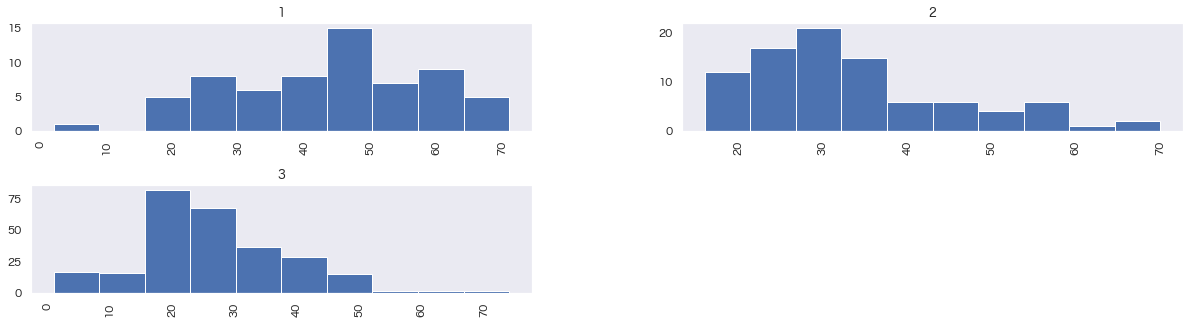

<Figure size 720x216 with 0 Axes>

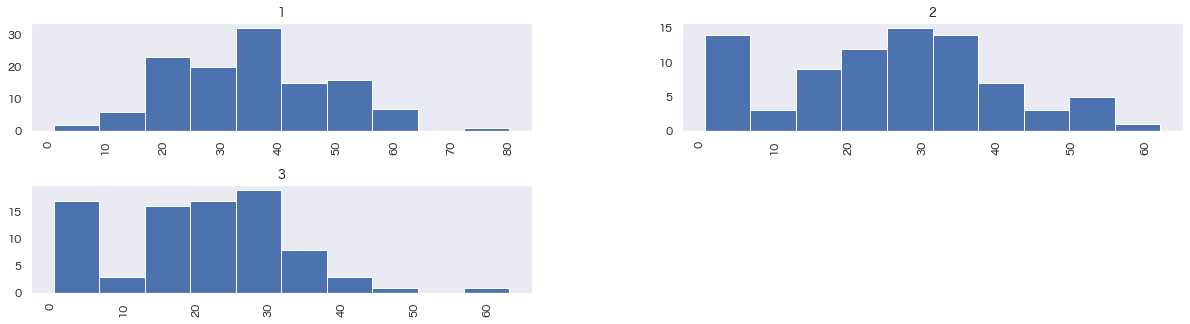

In [12]:
# 死亡者(Survived=0)、PclassごとのAge
plt.figure(figsize=[10,3])
train_df[train_df["Survived"]==0]["Age"].hist(by=train_df["Pclass"])
plt.show()

# 生存者(Suvived=1)、PclassごとのAge
plt.figure(figsize=[10,3])
train_df[train_df["Survived"]==1]["Age"].hist(by=train_df["Pclass"])
plt.show();

Cherbourg（Embarked='C'）


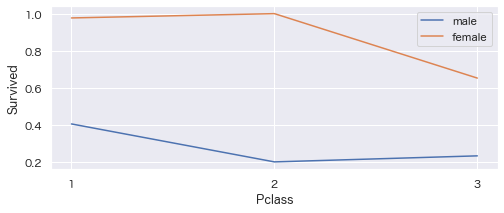

Cherbourg（Embarked='Q'）


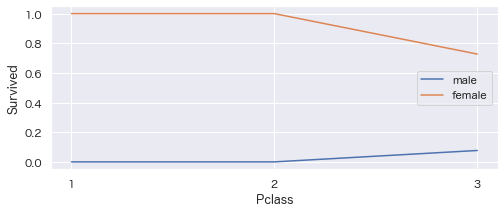

Cherbourg（Embarked='S'）


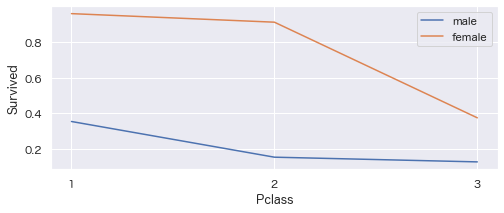

In [13]:
print("Cherbourg（Embarked='C'）")
# 出港した港がCherbourg（Embarked='C'）の時、SurvivedとPclass・Sexの関係（ピボットテーブル）
cor_category = train_df[train_df["Embarked"]=='C'][["Pclass", "Survived", "Sex"]].groupby(["Pclass", "Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

# 性別別にデータ分割
cor_category_male = cor_category[cor_category["Sex"]=='male'].sort_values('Pclass')
cor_category_female = cor_category[cor_category["Sex"]=='female'].sort_values('Pclass')

plt.figure(figsize=[8,3])
plt.grid()
plt.plot(['1', '2', '3'], cor_category_male["Survived"], label="male")
plt.plot(['1', '2', '3'], cor_category_female["Survived"], label="female")

plt.legend()
plt.xlabel("Pclass")
plt.ylabel("Survived")
plt.show()

print("Cherbourg（Embarked='Q'）")
# 出港した港がCherbourg（Embarked='Q'）の時、SurvivedとPclass・Sexの関係（ピボットテーブル）
cor_category = train_df[train_df["Embarked"]=='Q'][["Pclass", "Survived", "Sex"]].groupby(["Pclass", "Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

# 性別別にデータ分割
cor_category_male = cor_category[cor_category["Sex"]=='male'].sort_values('Pclass')
cor_category_female = cor_category[cor_category["Sex"]=='female'].sort_values('Pclass')

plt.figure(figsize=[8,3])
plt.grid()
plt.plot(['1', '2', '3'], cor_category_male["Survived"], label="male")
plt.plot(['1', '2', '3'], cor_category_female["Survived"], label="female")

plt.legend()
plt.xlabel("Pclass")
plt.ylabel("Survived")
plt.show()

print("Cherbourg（Embarked='S'）")
# 出港した港がCherbourg（Embarked='S'）の時、SurvivedとPclass・Sexの関係（ピボットテーブル）
cor_category = train_df[train_df["Embarked"]=='S'][["Pclass", "Survived", "Sex"]].groupby(["Pclass", "Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

# 性別別にデータ分割
cor_category_male = cor_category[cor_category["Sex"]=='male'].sort_values('Pclass')
cor_category_female = cor_category[cor_category["Sex"]=='female'].sort_values('Pclass')

plt.figure(figsize=[8,3])
plt.grid()
plt.plot(['1', '2', '3'], cor_category_male["Survived"], label="male")
plt.plot(['1', '2', '3'], cor_category_female["Survived"], label="female")

plt.legend()
plt.xlabel("Pclass")
plt.ylabel("Survived")
plt.show();

Cherbourg（Embarked='C'）


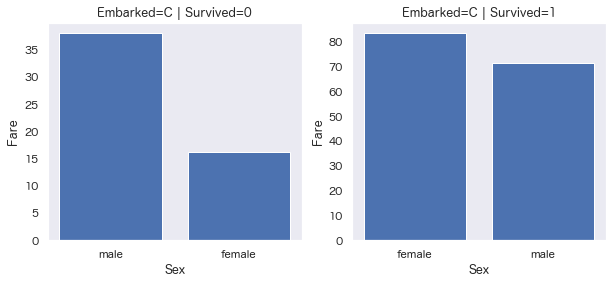

Cherbourg（Embarked='Q'）


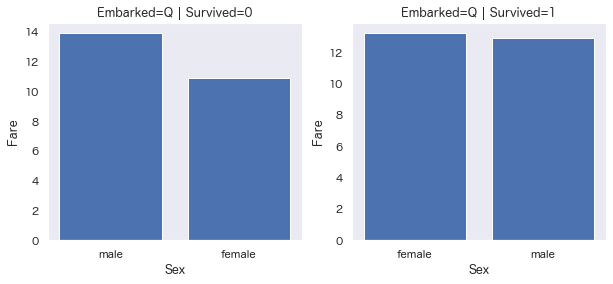

Cherbourg（Embarked='S'）


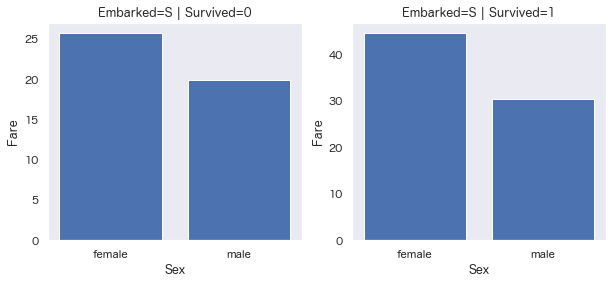

In [14]:
print("Cherbourg（Embarked='C'）")
# 出港した港がCherbourg（Embarked='C'）の時、SurvivedとPclass・Sexの関係（ピボットテーブル）
pivot = train_df[train_df["Embarked"]=='C'][["Survived", "Fare", "Sex"]].groupby(["Survived", "Sex"], as_index=False).mean().sort_values(by="Fare", ascending=False)

# Survivedが0（死亡）と1（生存）にデータを分割
pivot_category_0 = pivot[pivot["Survived"]==0]
pivot_category_1 = pivot[pivot["Survived"]==1]

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.bar(pivot_category_0["Sex"], pivot_category_0["Fare"])
axL.set_title('Embarked=C | Survived=0')
axL.set_xlabel('Sex')
axL.set_ylabel('Fare')

axR.bar(pivot_category_1["Sex"], pivot_category_1["Fare"])
axR.set_title('Embarked=C | Survived=1')
axR.set_xlabel('Sex')
axR.set_ylabel('Fare')

plt.show()

print("Cherbourg（Embarked='Q'）")
# 出港した港がCherbourg（Embarked='Q'）の時、SurvivedとPclass・Sexの関係（ピボットテーブル）
pivot = train_df[train_df["Embarked"]=='Q'][["Survived", "Fare", "Sex"]].groupby(["Survived", "Sex"], as_index=False).mean().sort_values(by="Fare", ascending=False)

# Survivedが0（死亡）と1（生存）にデータを分割
pivot_category_0 = pivot[pivot["Survived"]==0]
pivot_category_1 = pivot[pivot["Survived"]==1]

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.bar(pivot_category_0["Sex"], pivot_category_0["Fare"])
axL.set_title('Embarked=Q | Survived=0')
axL.set_xlabel('Sex')
axL.set_ylabel('Fare')

axR.bar(pivot_category_1["Sex"], pivot_category_1["Fare"])
axR.set_title('Embarked=Q | Survived=1')
axR.set_xlabel('Sex')
axR.set_ylabel('Fare')

plt.show()

print("Cherbourg（Embarked='S'）")
# 出港した港がCherbourg（Embarked='S'）の時、SurvivedとPclass・Sexの関係（ピボットテーブル）
pivot = train_df[train_df["Embarked"]=='S'][["Survived", "Fare", "Sex"]].groupby(["Survived", "Sex"], as_index=False).mean().sort_values(by="Fare", ascending=False)

# Survivedが0（死亡）と1（生存）にデータを分割
pivot_category_0 = pivot[pivot["Survived"]==0]
pivot_category_1 = pivot[pivot["Survived"]==1]

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.bar(pivot_category_0["Sex"], pivot_category_0["Fare"])
axL.set_title('Embarked=S | Survived=0')
axL.set_xlabel('Sex')
axL.set_ylabel('Fare')

axR.bar(pivot_category_1["Sex"], pivot_category_1["Fare"])
axR.set_title('Embarked=S | Survived=1')
axR.set_xlabel('Sex')
axR.set_ylabel('Fare')

plt.show();

# 特徴量エンジニアリング

## 特徴量削除

In [15]:
# train_dfから、TicketとCabinの特徴量を削除
train_df = train_df.drop(["Ticket", "Cabin"], axis=1)

# test_dfから、TicketとCabinの特徴量を削除
test_df = test_df.drop(["Ticket", "Cabin"], axis=1)

print ("-"*25+ "After"+ "-"*25)

train_df.shape
test_df.shape

-------------------------After-------------------------


(891, 10)

(418, 9)

## 欠損値補完 

In [16]:
# Embarkedの欠損値を削除、その最頻値でfreq_portを作成
freq_port = train_df["Embarked"].dropna().mode()[0]
freq_port

# 欠損値を最頻値で補完
train_df["Embarked"] = train_df["Embarked"].fillna(freq_port)
train_df.isnull().sum()

'S'

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

In [17]:
# test_dfのFareの欠損値を、Fareの中央値で補完
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].dropna().median())

test_df.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            0
Embarked        0
dtype: int64

In [18]:
# Age列の欠損値を、Ageの中央値で補完
combine = [train_df, test_df]
for dataset in combine:
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].dropna().median())
    print(dataset.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


In [19]:
combine = [train_df, test_df]
# Titleから敬称を抽出
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# SexとTitleでクロス集計
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


## 名寄せ

In [20]:
for dataset in combine:
    # 敬称を一律['Rare']に置換
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    # MileをMissに置換
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    # MmeをMrsに置換
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# 4. TitleとSurvivedで集計、Survivedの平均値を算出
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean();

## 数値変換

In [21]:
for dataset in combine:
    # Age（連続値）を5分割、離散値変換
    dataset['AgeBand'] = pd.cut(dataset['Age'], 5)

# AgeBandとSurvivedで集計
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",1
1,"(16.336, 32.252]",0
2,"(32.252, 48.168]",0
3,"(48.168, 64.084]",0
4,"(64.084, 80.0]",0


In [22]:
for dataset in combine:
    # # Fare（連続値）を4分割、離散値変換
    dataset['FareBand'] = pd.qcut(dataset['Fare'], 4)

# FareBandとSurvivedで集計
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0
1,"(7.91, 14.454]",0
2,"(14.454, 31.0]",0
3,"(31.0, 512.329]",1


## 特徴量生成

In [23]:
combine = [train_df, test_df]
# FamilySizeを作成
# ParchとSibSpを足し合わせる
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# FamilySizeとSurvivedで集計
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,1
2,3,1
1,2,1
6,7,0
0,1,0
4,5,0
5,6,0
7,8,0
8,11,0


In [24]:
for dataset in combine:
    # IsAloneを作成
    dataset['IsAlone'] = 0
    # 2. FamilySize=1の時、isAlone=1
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# IsAloneとSurvivedで集計
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,1
1,1,0


In [25]:
# 1. Age*Class新規作成、Age*Classを代入
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,66,22,3
1,38,38,1
2,78,26,3
3,35,35,1
4,105,35,3
5,84,28,3
6,54,54,1
7,6,2,3
8,81,27,3
9,28,14,2


In [26]:
for dataset in combine:
    # 性別ごとの年齢, 運賃, Pclass平均
    dataset["age_mean_by_sex"] = dataset.groupby(["Sex"])["Age"].transform("mean")
    dataset["fare_mean_by_sex"] = dataset.groupby(["Sex"])["Fare"].transform("mean")
    dataset["pclass_mean_by_sex"] = dataset.groupby(["Sex"])["Pclass"].transform("mean")

    # 年齢バンドごとの運賃, Pclass最大
    dataset["fare_max_by_ageband"] = dataset.groupby(["AgeBand"])["Fare"].transform("max")
    dataset["pclass_max_by_ageband"] = dataset.groupby(["AgeBand"])["Pclass"].transform("max")

## エンコーディング

In [27]:
# カテゴリ変数の変換
# ラベルエンコーディング
cat_columns = ["Sex", "Embarked", "Title"]

train_df = pd.get_dummies(train_df, columns=cat_columns)
test_df = pd.get_dummies(test_df, columns=cat_columns)

In [28]:
# カテゴリ変数の変換
# ラベルエンコーディング
train_df.head()
test_df.head()

lbe = LabelEncoder()
for dataset in combine:
    dataset['Sex_lbe'] = lbe.fit_transform(dataset['Sex'])
    dataset['Embarked_lbe'] = lbe.fit_transform(dataset['Embarked'])
    dataset['Title_lbe'] = lbe.fit_transform(dataset['Title'])
    dataset['AgeBand'] = lbe.fit_transform(dataset['AgeBand'])
    dataset['FareBand'] = lbe.fit_transform(dataset['FareBand'])
    
train_df.head()
test_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,AgeBand,FareBand,...,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0,3,"Braund, Mr. Owen Harris",22,1,0,7,"(16.336, 32.252]","(-0.001, 7.91]",...,0,1,0,0,1,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38,1,0,71,"(32.252, 48.168]","(31.0, 512.329]",...,1,0,1,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26,0,0,8,"(16.336, 32.252]","(7.91, 14.454]",...,1,0,0,0,1,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,1,0,53,"(32.252, 48.168]","(31.0, 512.329]",...,1,0,0,0,1,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35,0,0,8,"(32.252, 48.168]","(7.91, 14.454]",...,0,1,0,0,1,0,0,1,0,0


,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,AgeBand,FareBand,FamilySize,...,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,892,3,"Kelly, Mr. James",34,0,0,8,"(30.502, 45.668]","(-0.001, 7.896]",1,...,0,1,0,1,0,0,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47,1,0,7,"(45.668, 60.834]","(-0.001, 7.896]",2,...,1,0,0,0,1,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",62,0,0,10,"(60.834, 76.0]","(7.896, 14.454]",1,...,0,1,0,1,0,0,0,1,0,0
3,895,3,"Wirz, Mr. Albert",27,0,0,9,"(15.336, 30.502]","(7.896, 14.454]",1,...,0,1,0,0,1,0,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22,1,1,12,"(15.336, 30.502]","(7.896, 14.454]",3,...,1,0,0,0,1,0,0,0,1,0


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,AgeBand,FareBand,...,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0,3,"Braund, Mr. Owen Harris",22,1,0,7,"(16.336, 32.252]","(-0.001, 7.91]",...,0,1,0,0,1,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38,1,0,71,"(32.252, 48.168]","(31.0, 512.329]",...,1,0,1,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26,0,0,8,"(16.336, 32.252]","(7.91, 14.454]",...,1,0,0,0,1,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,1,0,53,"(32.252, 48.168]","(31.0, 512.329]",...,1,0,0,0,1,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35,0,0,8,"(32.252, 48.168]","(7.91, 14.454]",...,0,1,0,0,1,0,0,1,0,0


,PassengerId,Pclass,Name,Age


limit_output extension: Maximum message size of 10000 exceeded with 12752 characters

## 特徴量削除

In [29]:
# 特徴量削除
for dataset in combine:
    # NameとPassangerIdを削除（目的変数に無関係）
    dataset = dataset.drop(['Name', 'PassengerId'], axis=1, inplace=True)

combine = [train_df, test_df]
train_df.shape
test_df.shape

display(train_df.head())
display(test_df.head())

(891, 28)

(418, 27)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,AgeBand,FareBand,...,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0,3,"Braund, Mr. Owen Harris",22,1,0,7,"(16.336, 32.252]","(-0.001, 7.91]",...,0,1,0,0,1,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38,1,0,71,"(32.252, 48.168]","(31.0, 512.329]",...,1,0,1,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26,0,0,8,"(16.336, 32.252]","(7.91, 14.454]",...,1,0,0,0,1,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,1,0,53,"(32.252, 48.168]","(31.0, 512.329]",...,1,0,0,0,1,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35,0,0,8,"(32.252, 48.168]","(7.91, 14.454]",...,0,1,0,0,1,0,0,1,0,0


,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,AgeBand,FareBand,FamilySize,...,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,892,3,"Kelly, Mr. James",34,0,0,8,"(30.502, 45.668]","(-0.001, 7.896]",1,...,0,1,0,1,0,0,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47,1,0,7,"(45.668, 60.834]","(-0.001, 7.896]",2,...,1,0,0,0,1,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",62,0,0,10,"(60.834, 76.0]","(7.896, 14.454]",1,...,0,1,0,1,0,0,0,1,0,0
3,895,3,"Wirz, Mr. Albert",27,0,0,9,"(15.336, 30.502]","(7.896, 14.454]",1,...,0,1,0,0,1,0,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22,1,1,12,"(15.336, 30.502]","(7.896, 14.454]",3,...,1,0,0,0,1,0,0,0,1,0


## 一括処理

In [30]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# 特徴量削除
train_df = train_df.drop(["Ticket", "Cabin"], axis=1)
test_df = test_df.drop(["Ticket", "Cabin"], axis=1)
combine = [train_df, test_df]

# 置換
freq_port = train_df["Embarked"].dropna().mode()[0]
train_df["Embarked"] = train_df["Embarked"].fillna(freq_port)
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].dropna().median())
combine = [train_df, test_df]
for dataset in combine:
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].dropna().median())
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['AgeBand'] = pd.cut(dataset['Age'], 5)
    dataset['FareBand'] = pd.qcut(dataset['Fare'], 4)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset['Age*Class'] = dataset.Age * dataset.Pclass
    
# ラベルエンコーディング
lbe = LabelEncoder()
for dataset in combine:
    dataset['Sex_lbe'] = lbe.fit_transform(dataset['Sex'])
    dataset['Embarked_lbe'] = lbe.fit_transform(dataset['Embarked'])
    dataset['Title_lbe'] = lbe.fit_transform(dataset['Title'])
    dataset['AgeBand'] = lbe.fit_transform(dataset['AgeBand'])
    dataset['FareBand'] = lbe.fit_transform(dataset['FareBand'])

# 特徴量削除
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name', 'PassengerId'], axis=1)
train_df.head()
test_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand,FareBand,FamilySize,IsAlone,Age*Class,Sex_lbe,Embarked_lbe,Title_lbe
0,0,3,male,22,1,0,7,S,Mr,1,0,2,0,66,1,2,2
1,1,1,female,38,1,0,71,C,Mrs,2,3,2,0,38,0,0,3
2,1,3,female,26,0,0,8,S,Miss,1,1,1,1,78,0,2,1
3,1,1,female,35,1,0,53,S,Mrs,2,3,2,0,35,0,2,3
4,0,3,male,35,0,0,8,S,Mr,2,1,1,1,105,1,2,2


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand,FareBand,FamilySize,IsAlone,Age*Class,Sex_lbe,Embarked_lbe,Title_lbe
0,3,male,34,0,0,8,Q,Mr,2,0,1,1,104,1,1,2
1,3,female,47,1,0,7,S,Mrs,3,0,2,0,141,0,2,3
2,2,male,62,0,0,10,Q,Mr,4,1,1,1,124,1,1,2
3,3,male,27,0,0,9,S,Mr,1,1,1,1,81,1,2,2
4,3,female,22,1,1,12,S,Mrs,1,1,3,0,66,0,2,3


## 特徴量選択

In [31]:
# 特徴量選択
# original_columns: 初期の特徴量
# X_trainに[original_columns]を格納
original_columns = ['Pclass', 'Sex_lbe', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_lbe','Title_lbe']

X_train = train_df[original_columns]
y_train = train_df["Survived"]
X_test  = test_df[original_columns]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

display(X_train.head())
display(y_train.head());

(891, 8)
(891,)
(418, 8)


,Pclass,Sex_lbe,Age,SibSp,Parch,Fare,Embarked_lbe,Title_lbe
0,3,1,22,1,0,7,2,2
1,1,0,38,1,0,71,0,3
2,3,0,26,0,0,8,2,1
3,1,0,35,1,0,53,2,3
4,3,1,35,0,0,8,2,2


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# データ分割

In [32]:
# 学習用データと評価用データに分割
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
model = LogisticRegression(solver='liblinear')
model.fit(X_trn, y_trn)
acc = model.score(X_val, y_val)
print("accuracy:", acc.round(decimals=3));

accuracy: 0.803


## 交差検証（いろいろ）

In [33]:
# KFold
cv = KFold(n_splits=3, random_state=42, shuffle=True)
acc_results = []
for trn_index, val_index in cv.split(X_train):
    X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
    y_trn, y_val = y_train[trn_index], y_train[val_index]
    model = LogisticRegression(solver='liblinear')
    model.fit(X_trn, y_trn)
    acc = model.score(X_val, y_val)
    print("acc:", acc.round(decimals=3))
    acc_results.append(acc.round(decimals=3))

print(acc_results)
print("Average:", np.mean(acc_results).round(decimals=3));

acc: 0.805
acc: 0.798
acc: 0.781
[0.805, 0.798, 0.781]
Average: 0.795


In [34]:
# Out Of Fold(oof)
cv = KFold(n_splits=3, random_state=42, shuffle=True)

# oof_predicts: 学習データ全体の予測値
oof_predicts = np.zeros(len(y_train))
for trn_index, val_index in cv.split(X_train):
    X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
    y_trn, y_val = y_train[trn_index], y_train[val_index]
    model = LogisticRegression(solver='liblinear')
    model.fit(X_trn, y_trn)
    # oof_predictionsの内、バリデーションデータ（各fold）のインデックス（oof）を予測して保存
    oof_predicts[val_index] = model.predict(X_val)
    
print(accuracy_score(y_train, oof_predicts).round(decimals=3));

0.795


In [35]:
# StratifiedKFold
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
acc_results = []
for trn_index, val_index in cv.split(X_train, y_train):
    X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
    y_trn, y_val = y_train[trn_index], y_train[val_index]
    model = LogisticRegression(solver='liblinear')
    model.fit(X_trn, y_trn)
    acc = model.score(X_val, y_val)
    print("acc:", acc.round(decimals=3))
    acc_results.append(acc.round(decimals=3))
    
print(acc_results)
print("Average:", np.mean(acc_results).round(decimals=3));

acc: 0.801
acc: 0.778
acc: 0.822
[0.801, 0.778, 0.822]
Average: 0.8


In [36]:
# GroupKFold
cv = GroupKFold(n_splits=3)
acc_results = []

for trn_index, val_index in cv.split(X_train, y_train, groups=X_train["Pclass"]): # gourps引数でグループの配列を指定
    X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
    y_trn, y_val = y_train[trn_index], y_train[val_index]
    model = LogisticRegression(solver='liblinear')
    model.fit(X_trn, y_trn)
    acc = model.score(X_val, y_val)
    print("acc:", acc.round(decimals=3))
    acc_results.append(acc.round(decimals=3))
    
print(acc_results)
print("Average:", np.mean(acc_results).round(decimals=3));

acc: 0.731
acc: 0.727
acc: 0.864
[0.731, 0.727, 0.864]
Average: 0.774


# 各モデルの学習、予測、評価

In [37]:
# 学習、予測、評価の反復用関数
def run_cv(model):
    cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
    acc_results = []
    for trn_index, val_index in cv.split(X_train, y_train):
        X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
        y_trn, y_val = y_train[trn_index], y_train[val_index]
        model.fit(X_trn, y_trn) # モデル学習
        acc = model.score(X_val, y_val) # モデル精度算出
        acc_results.append(acc.round(decimals=3))

    print(acc_results)
    print("Average acc:", np.mean(acc_results).round(decimals=3))

In [39]:
run_cv(LogisticRegression(solver='liblinear'))

[0.801, 0.778, 0.822]
Average acc: 0.8


In [40]:
# 特徴量の偏回帰係数を算出
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Partial regression coefficient"] = pd.Series(model.coef_[0])

coeff_df.sort_values(by="Partial regression coefficient", ascending=False)

LogisticRegression(solver='liblinear')

,Feature,Partial regression coefficient
5,Fare,0
2,Age,-0
4,Parch,-0
7,Title,-0
6,Embarked,-0
3,SibSp,-0
0,Pclass,-1
1,Sex,-2
8,AgeBand,nan
9,FareBand,nan


In [41]:
# サポートベクターマシン
run_cv(SVC())

[0.687, 0.667, 0.69]
Average acc: 0.681


In [42]:
# k-Nearest Neighbors(k近傍法)
# 1. k-NN法による分類モデルを作成し、モデルの精度出力
run_cv(KNeighborsClassifier(n_neighbors=3))

[0.754, 0.707, 0.744]
Average acc: 0.735


In [43]:
# ナイーブベイズ分類器
run_cv(GaussianNB())

[0.785, 0.805, 0.808]
Average acc: 0.799


In [44]:
# パーセプトロン
run_cv(Perceptron())

[0.744, 0.616, 0.593]
Average acc: 0.651


In [45]:
# 確率的勾配降下法
run_cv(SGDClassifier())

[0.768, 0.663, 0.764]
Average acc: 0.732


In [46]:
# 決定木
run_cv(DecisionTreeClassifier())

[0.791, 0.764, 0.768]
Average acc: 0.774


In [47]:
# ランダムフォレスト
run_cv(RandomForestClassifier())

[0.815, 0.805, 0.822]
Average acc: 0.814


In [48]:
# LightGBMz
lgb_params = {
    "objective":"binary",
    "metric": "binary_error"
}

cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
acc_results = []
for trn_index, val_index in cv.split(X_train, y_train):
    X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
    y_trn, y_val = y_train[trn_index], y_train[val_index]
    
    train_lgb = lgb.Dataset(X_trn, y_trn)
    validation_lgb = lgb.Dataset(X_val, y_val)
    model = lgb.train(lgb_params, train_lgb, num_boost_round=1000, valid_sets=[train_lgb, validation_lgb], verbose_eval=10, categorical_feature=["Pclass", "Sex_lbe", "Embarked_lbe"], early_stopping_rounds=100)
    pred = model.predict(X_val)
    pred = np.where(pred>=0.5, 1, 0)
    acc = accuracy_score(y_val, pred)
    
    acc_results.append(acc.round(decimals=3))

[LightGBM] [Info] Number of positive: 228, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 594, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Embarked_lbe', 'Pclass', 'Sex_lbe']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	training's binary_error: 0.0639731	valid_1's binary_error: 0.151515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

limit_output extension: Maximum message size of 10000 exceeded with 13001 characters

In [49]:
print(acc_results)
print("Average acc:", np.mean(acc_results).round(decimals=3))

[0.865, 0.832, 0.859]
Average acc: 0.852


In [50]:
# 予測、クロスバリデーション
lgb_params = {
    "objective":"binary",
    "metric": "binary_error"
}
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True) # StratifiedKFold

test_preds = np.zeros(len(X_test))
for trn_index, val_index in cv.split(X_train, y_train):
    X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
    y_trn, y_val = y_train[trn_index], y_train[val_index]
    
    train_lgb = lgb.Dataset(X_trn, y_trn)
    validation_lgb = lgb.Dataset(X_val, y_val)
    model = lgb.train(lgb_params, train_lgb, num_boost_round=1000, valid_sets=[train_lgb, validation_lgb], verbose_eval=200, categorical_feature=["Pclass", "Sex_lbe", "Embarked_lbe"], early_stopping_rounds=100)
    pred = model.predict(X_val)
    pred = np.where(pred>=0.5, 1, 0)
    acc = accuracy_score(y_val, pred)
    acc_results.append(acc)
    
    # 予測値をfold数で割ったものを足す
    test_preds += model.predict(X_test) / cv.n_splits

[LightGBM] [Info] Number of positive: 228, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 594, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Embarked_lbe', 'Pclass', 'Sex_lbe']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

limit_output extension: Maximum message size of 10000 exceeded with 12995 characters

In [51]:
print("Average acc:", np.mean(acc_results).round(decimals=3))

Average acc: 0.852


In [52]:
# 提出ファイル作成
submission = pd.read_csv("./gender_submission.csv")
submission["Survived"] = np.where(test_preds>=0.5, 1, 0)
display(submission.head(10))
# 提出ファイルを出力
submission.to_csv("first_submission.csv", index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


# 特徴量追加

In [53]:
# 作成した特徴量を追加
original_columns =['Pclass', 'Sex_lbe', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_lbe']
my_columns = ['Title_lbe', 'AgeBand', 'FareBand', 'FamilySize', 'IsAlone',
       'Age*Class']
X_train = train_df[original_columns+my_columns]
X_test = test_df[original_columns+my_columns]

lgb_params = {
    "objective":"binary",
    "metric": "binary_error",
    "random_state":42
}
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

acc_results = []
for trn_index, val_index in cv.split(X_train, y_train):
    X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
    y_trn, y_val = y_train[trn_index], y_train[val_index]
    train_lgb = lgb.Dataset(X_trn, y_trn)
    validation_lgb = lgb.Dataset(X_val, y_val)
    
    model = lgb.train(lgb_params,
                      train_lgb, num_boost_round=1000,
                      valid_sets=[train_lgb, validation_lgb],
                      verbose_eval=50,
                      categorical_feature=["Pclass", "Sex_lbe", "Embarked_lbe", "Title_lbe", "IsAlone"],
                      early_stopping_rounds=100)
    
    pred = model.predict(X_val)
    pred = np.where(pred>=0.5, 1, 0)
    
    acc = accuracy_score(y_val, pred)
    acc_results.append(acc.round(decimals=3))

/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Embarked_lbe', 'IsAlone', 'Pclass', 'Sex_lbe', 'Title_lbe']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 228, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 594, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

limit_output extension: Maximum message size of 10000 exceeded with 12642 characters

In [54]:
print(acc_results)
print("Average acc:", np.mean(acc_results).round(decimals=3))

[0.862, 0.825, 0.859]
Average acc: 0.849


# 特徴量重要度

In [55]:
# 特徴量重要度（LightGBM）
lgb_params = {
    "objective":"binary",
    "metric": "binary_error",
    "random_state":42
}
train_lgb = lgb.Dataset(X_train, y_train)
model = lgb.train(lgb_params, 
                  train_lgb, 
                  num_boost_round=1000, 
                  verbose_eval=False, 
                  categorical_feature=["Pclass", "Sex_lbe", "Embarked_lbe", "Title_lbe", "IsAlone"])

importance_df = pd.DataFrame({
    "feature_names":model.feature_name(),
    "importances":model.feature_importance("gain")
})

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288


/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Embarked_lbe', 'IsAlone', 'Pclass', 'Sex_lbe', 'Title_lbe']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

limit_output extension: Maximum message size of 10000 exceeded with 11131 characters

In [56]:
importance_df.sort_values("importances", ascending=False)

,feature_names,importances
5,Fare,1430
1,Sex_lbe,1384
12,Age*Class,1003
2,Age,833
0,Pclass,438
10,FamilySize,233
7,Title_lbe,199
6,Embarked_lbe,141
3,SibSp,95
4,Parch,59


In [57]:
# 特徴量重要度（LightGBM、StratifiedKFold）
lgb_params = {
    "objective":"binary",
    "metric": "binary_error",
    "random_state":42
}

cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

acc_results = []
feature_importance_df = pd.DataFrame({"feature_names":[], "importances":[]})
for trn_index, val_index in cv.split(X_train, y_train):
    X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
    y_trn, y_val = y_train[trn_index], y_train[val_index]
    
    # 学習用データセット作成
    train_lgb = lgb.Dataset(X_trn, y_trn)
    validation_lgb = lgb.Dataset(X_val, y_val)
    
    model = lgb.train(lgb_params,
                      train_lgb,
                      num_boost_round=1000,
                      valid_sets=[train_lgb, validation_lgb],
                      verbose_eval=False,
                      categorical_feature=["Pclass", "Sex_lbe", "Embarked_lbe", "Title_lbe", "IsAlone"],
                      early_stopping_rounds=100)
    
    pred = model.predict(X_val)
    pred = np.where(pred>=0.5, 1, 0)
    
    acc = accuracy_score(y_val, pred)
    acc_results.append(acc)
    
    feature_importance_df = pd.concat((feature_importance_df, pd.DataFrame(
        {"feature_names": model.feature_name(), "importances": model.feature_importance()})))

/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Embarked_lbe', 'IsAlone', 'Pclass', 'Sex_lbe', 'Title_lbe']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 228, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 594, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

limit_output extension: Maximum message size of 10000 exceeded with 12959 characters

,importances
feature_names,
Fare,368
Age,213
Age*Class,177
Embarked_lbe,43
Pclass,40
FamilySize,29
Sex_lbe,26
Title_lbe,19
SibSp,17


<AxesSubplot:xlabel='importances', ylabel='feature_names'>

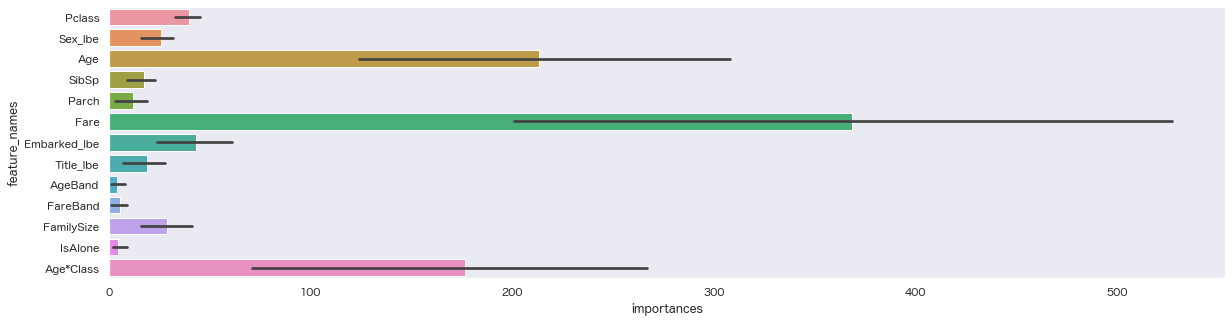

In [58]:
# 特徴量重要度
feature_importance_df.groupby("feature_names").mean().sort_values("importances", ascending=False)

# 棒グラフ
sns.barplot(x="importances", y="feature_names", data=feature_importance_df)

# パラメータチューニング

In [70]:
# ログを非表示にする（長いため）
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 探索用関数を定義
def objective(trial):
    # パラメータ
    params = {
        "objective":"binary",
        "metric": "binary_error",
        "random_state":42,
        "num_leaves": trial.suggest_int('num_leaves', 2, 2**10), # 2~2^10の範囲で探索
        "bagging_fraction": trial.suggest_uniform('baggin_fraction', 0.1, 0.9), # 0.1~0.9の範囲で探索
    }
    
    # クロスバリデーションでモデルを評価
    cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True) # 3foldのクロスバリデーションの平均精度を目的値とする
    acc_results = []
    for trn_index, val_index in cv.split(X_train, y_train):
        X_trn, X_val = X_train.loc[trn_index], X_train.loc[val_index]
        y_trn, y_val = y_train[trn_index], y_train[val_index]

        train_lgb = lgb.Dataset(X_trn, y_trn)
        validation_lgb = lgb.Dataset(X_val, y_val)
        
        model = lgb.train(params,
                          train_lgb,
                          num_boost_round=1000,
                          valid_sets=[train_lgb,validation_lgb],
                          verbose_eval=False, 
                          categorical_feature=["Pclass", "Sex_lbe", "Embarked_lbe", "Title_lbe", "IsAlone"], 
                          early_stopping_rounds=100)
        
        pred = model.predict(X_val)
        pred = np.where(pred>=0.5, 1, 0)
        
        acc = accuracy_score(y_val, pred)
        acc_results.append(acc.round(decimals=3))
        
    return np.mean(acc_results)

In [71]:
# 目的値を最大化するインスタンスを生成
study = optuna.create_study(direction="maximize")
# 最適化開始
study.optimize(objective, n_trials=30) # 回数、時間を指定

[LightGBM] [Info] Number of positive: 228, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 594, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

limit_output extension: Maximum message size of 10000 exceeded with 13204 characters

best_value 0.8486666666666666
best_params {'num_leaves': 270, 'baggin_fraction': 0.8382098081339157}


,number,value,params_baggin_fraction,params_num_leaves
0,0,1,1,270
1,1,1,0,80
2,2,1,0,104
3,3,1,1,1021
4,4,1,0,188
5,5,1,1,827
6,6,1,1,51
7,7,1,0,87
8,8,1,0,585
9,9,1,0,872


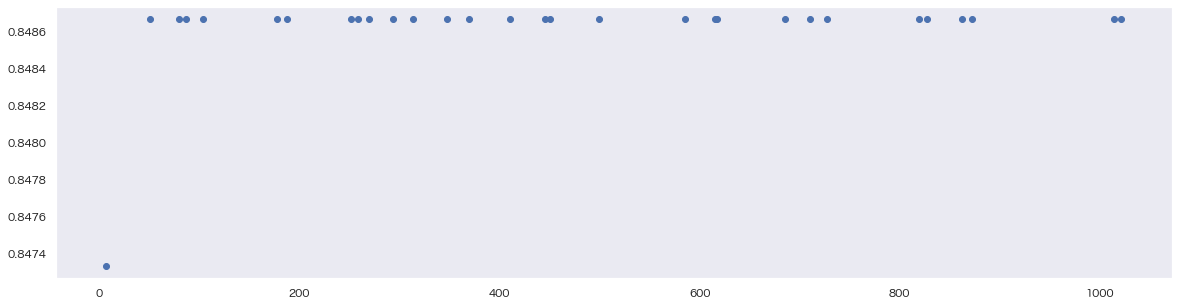

In [74]:
print("best_value", study.best_value) # 最適な精度
print("best_params", study.best_params) # 最適なパラメータ

# 最適化の過程を可視化
optuna_log_df = study.trials_dataframe(attrs=("number", "value", "params"))
display(optuna_log_df)

# 精度とnum_leavesパラメータの関係をプロット
plt.scatter(optuna_log_df["params_num_leaves"], optuna_log_df["value"]);

# アンサンブル

In [60]:
# アンサンブル①
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42) # ホールドアウト法

# ロジスティック回帰とLightgbmとランダムフォレスト
models = [LogisticRegression(solver='liblinear'), LGBMClassifier(), RandomForestClassifier()]
predictions = []
for model in models:
    model.fit(X_trn, y_trn)
    pred_by_model = model.predict_proba(X_val) # 各クラスに属する確率を予測
    print(f"{model.__class__.__name__}:", accuracy_score(y_val, np.argmax(pred_by_model, axis=1)).round(decimals=3))
    predictions.append(pred_by_model)

# 3つのモデルの平均値を取得
mean_emsemble_proba = np.mean(predictions, axis=0)
# 各クラスに属する予測確率を予測クラスに直す
mean_emsemble = np.argmax(mean_emsemble_proba, axis=1)

print("\nmean emesemble accuracy", accuracy_score(y_val, mean_emsemble).round(decimals=3));

LogisticRegression: 0.783
LGBMClassifier: 0.803
RandomForestClassifier: 0.803

mean emesemble accuracy 0.824


In [62]:
# アンサンブル②（スタッキング）

# ホールドアウト法
X_train_hold, X_val_hold, y_train_hold, y_val_hold = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
X_train_hold = X_train_hold.reset_index(drop=True)
X_val_hold = X_val_hold.reset_index(drop=True)
y_train_hold = y_train_hold.reset_index(drop=True)
y_val_hold = y_val_hold.reset_index(drop=True)

# ロジスティック回帰とLightgbmとランダムフォレスト
models = [LogisticRegression(solver='liblinear'), LGBMClassifier(), RandomForestClassifier()]

predictions = []
for model in models:
    cv = KFold(n_splits=3, random_state=42, shuffle=True)

    kf_predicts_by_model = np.zeros(len(y_train_hold))
    for trn_index, val_index in cv.split(X_train_hold):
        X_trn, X_val = X_train_hold.loc[trn_index], X_train_hold.loc[val_index]
        y_trn, y_val = y_train_hold[trn_index], y_train_hold[val_index]

        model.fit(X_trn, y_trn)

        kf_predicts_by_model[val_index] = model.predict_proba(X_val)[:, 1]
        
    predictions.append(kf_predicts_by_model)

# 2層目の学習データとして用いる為、学習データの予測値を取得
kf_train = pd.DataFrame({"lr_prediction":predictions[0], "lgbm_prediction":predictions[1], "rf_prediction":predictions[2]})
display(kf_train)

# テストデータの予測値を取得
predictions_test = []
for model in models:
    model.fit(X_train_hold, y_train_hold)
    predict_test = model.predict_proba(X_val_hold)[:,1]
    predictions_test.append(predict_test)

# 2層目の予測データとして用いるため、テストデータの予測値を取得
kf_test = pd.DataFrame({"lr_prediction":predictions_test[0], "lgbm_prediction":predictions_test[1], "rf_prediction":predictions_test[2]})
display(kf_test)

# 2層目はロジスティック回帰で予測
lr_model_2nd = LogisticRegression()
lr_model_2nd.fit(kf_train, y_train_hold)
predict_stacking = lr_model_2nd.predict(kf_test)
score = accuracy_score(y_val_hold, predict_stacking)
print("stacking accuracy:", score.round(decimals=3));

,lr_prediction,lgbm_prediction,rf_prediction
0,1,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,1,0,0
...,...,...,...
591,1,1,0
592,0,1,1
593,0,0,0
594,1,1,1


,lr_prediction,lgbm_prediction,rf_prediction
0,0,0,1
1,0,0,0
2,0,0,0
3,1,1,1
4,1,0,0
...,...,...,...
290,0,0,0
291,0,0,0
292,1,1,1
293,1,1,1


stacking accuracy: 0.817
